#### 0. project discription

Mars Rover Environmental Monitoring Station Data

Objective - UV Radiation classification


#### 01. load libraries

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

import bentoml

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [3]:
df = pd.read_csv('REMS_Mars_Dataset.csv')
df.columns = df.columns.str.lower()

In [4]:
df.head().T

,0,1,2,3,4
earth_date_time,"Earth, 2022-01-26 UTC","Earth, 2022-01-25 UTC","Earth, 2022-01-24 UTC","Earth, 2022-01-23 UTC","Earth, 2022-01-22 UTC"
mars_date_time,"Mars, Month 6 - LS 163°","Mars, Month 6 - LS 163°","Mars, Month 6 - LS 162°","Mars, Month 6 - LS 162°","Mars, Month 6 - LS 161°"
sol_number,Sol 3368,Sol 3367,Sol 3366,Sol 3365,Sol 3364
max_ground_temp(°c),-3,-3,-4,-6,-7
min_ground_temp(°c),-71,-72,-70,-70,-71
max_air_temp(°c),10,10,8,9,8
min_air_temp(°c),-84,-87,-81,-91,-92
mean_pressure(pa),707,707,708,707,708
wind_speed(m/h),Value not available,Value not available,Value not available,Value not available,Value not available
humidity(%),Value not available,Value not available,Value not available,Value not available,Value not available


In [5]:
df.describe().round()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°c),min_ground_temp(°c),max_air_temp(°c),min_air_temp(°c),mean_pressure(pa),wind_speed(m/h),humidity(%),sunrise,sunset,uv_radiation,weather
count,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3170,3197
unique,3197,360,3197,52,40,51,78,224,1,1,90,96,4,2
top,"Earth, 2022-01-26 UTC","Mars, Month 3 - LS 86°",Sol 3368,-6,-79,14,-78,873,Value not available,Value not available,05:18,17:20,moderate,Sunny
freq,1,12,1,130,221,154,165,47,3197,3197,170,199,1450,3194


In [6]:
df = df.replace(r'Value not available', np.NaN, regex=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   earth_date_time      3197 non-null   object 
 1   mars_date_time       3197 non-null   object 
 2   sol_number           3197 non-null   object 
 3   max_ground_temp(°c)  3169 non-null   object 
 4   min_ground_temp(°c)  3169 non-null   object 
 5   max_air_temp(°c)     3168 non-null   object 
 6   min_air_temp(°c)     3168 non-null   object 
 7   mean_pressure(pa)    3170 non-null   object 
 8   wind_speed(m/h)      0 non-null      float64
 9   humidity(%)          0 non-null      float64
 10  sunrise              3197 non-null   object 
 11  sunset               3197 non-null   object 
 12  uv_radiation         3170 non-null   object 
 13  weather              3194 non-null   object 
dtypes: float64(2), object(12)
memory usage: 349.8+ KB


In [8]:
df = df.rename(columns={
  'max_ground_temp(°c)': 'max_ground_temp', 
  'min_ground_temp(°c)': 'min_ground_temp',
  'max_air_temp(°c)': 'max_air_temp',
  'min_air_temp(°c)': 'min_air_temp',
  'mean_pressure(pa)': 'mean_pressure',
  'wind_speed(m/h)': 'wind_speed',
  'humidity(%)': 'humidity',

  })

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   earth_date_time  3197 non-null   object 
 1   mars_date_time   3197 non-null   object 
 2   sol_number       3197 non-null   object 
 3   max_ground_temp  3169 non-null   object 
 4   min_ground_temp  3169 non-null   object 
 5   max_air_temp     3168 non-null   object 
 6   min_air_temp     3168 non-null   object 
 7   mean_pressure    3170 non-null   object 
 8   wind_speed       0 non-null      float64
 9   humidity         0 non-null      float64
 10  sunrise          3197 non-null   object 
 11  sunset           3197 non-null   object 
 12  uv_radiation     3170 non-null   object 
 13  weather          3194 non-null   object 
dtypes: float64(2), object(12)
memory usage: 349.8+ KB


#### 02. E.D.A

In [9]:
df.head().T

,0,1,2,3,4
earth_date_time,"Earth, 2022-01-26 UTC","Earth, 2022-01-25 UTC","Earth, 2022-01-24 UTC","Earth, 2022-01-23 UTC","Earth, 2022-01-22 UTC"
mars_date_time,"Mars, Month 6 - LS 163°","Mars, Month 6 - LS 163°","Mars, Month 6 - LS 162°","Mars, Month 6 - LS 162°","Mars, Month 6 - LS 161°"
sol_number,Sol 3368,Sol 3367,Sol 3366,Sol 3365,Sol 3364
max_ground_temp,-3,-3,-4,-6,-7
min_ground_temp,-71,-72,-70,-70,-71
max_air_temp,10,10,8,9,8
min_air_temp,-84,-87,-81,-91,-92
mean_pressure,707,707,708,707,708
wind_speed,NaN,NaN,NaN,NaN,NaN
humidity,NaN,NaN,NaN,NaN,NaN


In [10]:
float_measurements = ['max_ground_temp', 'min_ground_temp', 'max_air_temp', 'min_air_temp', 'mean_pressure', 'wind_speed','humidity']
df[float_measurements] = df[float_measurements].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   earth_date_time  3197 non-null   object 
 1   mars_date_time   3197 non-null   object 
 2   sol_number       3197 non-null   object 
 3   max_ground_temp  3169 non-null   float64
 4   min_ground_temp  3169 non-null   float64
 5   max_air_temp     3168 non-null   float64
 6   min_air_temp     3168 non-null   float64
 7   mean_pressure    3170 non-null   float64
 8   wind_speed       0 non-null      float64
 9   humidity         0 non-null      float64
 10  sunrise          3197 non-null   object 
 11  sunset           3197 non-null   object 
 12  uv_radiation     3170 non-null   object 
 13  weather          3194 non-null   object 
dtypes: float64(7), object(7)
memory usage: 349.8+ KB


In [11]:
df.describe()

,max_ground_temp,min_ground_temp,max_air_temp,min_air_temp,mean_pressure,wind_speed,humidity
count,3169.000000,3169.000000,3168.000000,3168.000000,3170.000000,0.0,0.0
mean,-13.209214,-75.016409,2.010732,-80.317551,828.792429,NaN,NaN
std,10.493719,5.529282,9.401705,8.845239,57.119649,NaN,NaN
min,-67.000000,-100.000000,-61.000000,-136.000000,702.000000,NaN,NaN
25%,-23.000000,-79.000000,-6.000000,-86.000000,785.000000,NaN,NaN
50%,-12.000000,-75.000000,3.000000,-80.000000,843.000000,NaN,NaN
75%,-4.000000,-71.000000,10.000000,-75.000000,873.000000,NaN,NaN
max,11.000000,-52.000000,24.000000,-8.000000,925.000000,NaN,NaN


In [12]:
df.drop(['wind_speed', 'humidity'], axis = 1, inplace = True)
df.isnull().sum(axis = 0)

earth_date_time     0
mars_date_time      0
sol_number          0
max_ground_temp    28
min_ground_temp    28
max_air_temp       29
min_air_temp       29
mean_pressure      27
sunrise             0
sunset              0
uv_radiation       27
weather             3
dtype: int64

In [13]:
df['uv_radiation'].value_counts()
# try multiclass classification

moderate     1450
high         1352
very_high     284
low            84
Name: uv_radiation, dtype: int64

In [14]:
df['uv_radiation'] = df['uv_radiation'].replace(r'very_high', 'high', regex=True)
df['uv_radiation'] = df['uv_radiation'].replace(r'moderate', 'low', regex=True)
# df['uv_radiation'].value_counts().sum()


In [15]:
df.corr().style.background_gradient(cmap='coolwarm')

/var/folders/ts/4n4696j93m3gbfdw1gxpvf880000gn/T/ipykernel_70160/543879950.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='coolwarm')


,max_ground_temp,min_ground_temp,max_air_temp,min_air_temp,mean_pressure
max_ground_temp,1.000000,0.675214,0.822246,0.489733,-0.055342
min_ground_temp,0.675214,1.000000,0.570791,0.646849,-0.005307
max_air_temp,0.822246,0.570791,1.000000,0.268380,-0.088271
min_air_temp,0.489733,0.646849,0.268380,1.000000,0.032279
mean_pressure,-0.055342,-0.005307,-0.088271,0.032279,1.000000


In [16]:
df.shape[0]

3197

#### 03. modelling

In [17]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
df_train.uv_radiation.unique()

array(['high', 'low', nan], dtype=object)

In [20]:
y_train = (df_train.uv_radiation == 'high').astype('int').values
y_val = (df_val.uv_radiation == 'high').astype('int').values
y_test = (df_test.uv_radiation == 'high').astype('int').values

In [21]:
del df_train['uv_radiation']
del df_val['uv_radiation']
del df_test['uv_radiation']

In [22]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()

In [23]:
df_train.shape, df_val.shape

((1917, 11), (640, 11))

##### 03a. modelling - decision trees

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   earth_date_time  1917 non-null   object 
 1   mars_date_time   1917 non-null   object 
 2   sol_number       1917 non-null   object 
 3   max_ground_temp  1898 non-null   float64
 4   min_ground_temp  1898 non-null   float64
 5   max_air_temp     1897 non-null   float64
 6   min_air_temp     1897 non-null   float64
 7   mean_pressure    1899 non-null   float64
 8   sunrise          1917 non-null   object 
 9   sunset           1917 non-null   object 
 10  weather          1916 non-null   object 
dtypes: float64(5), object(6)
memory usage: 164.9+ KB


In [25]:
# df_train = df_train[ num_cols + ['weather']]
# df_train.head().T

In [26]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[ num_cols + ['weather']].fillna(0).to_dict(orient='records')
val_dicts = df_val[ num_cols + ['weather'] ].fillna(0).to_dict(orient='records')
# train_dicts = df_train.fillna(0).to_dict(orient='records')
# val_dicts = df_val.fillna(0).to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)


In [27]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]

print('basic desicion tree (AUC):', roc_auc_score(y_val, y_pred))

basic desicion tree (AUC): 0.813373253493014


In [28]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train (AUC):', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('validation (AUC):', auc)

train (AUC): 0.7510907347476926
validation (AUC): 0.7440070838714727


In [30]:
print(export_text(dt, feature_names=dv.get_feature_names()))
# print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- max_air_temp <= 3.50
|   |--- max_air_temp <= -5.50
|   |   |--- class: 0
|   |--- max_air_temp >  -5.50
|   |   |--- class: 0
|--- max_air_temp >  3.50
|   |--- mean_pressure <= 713.50
|   |   |--- class: 0
|   |--- mean_pressure >  713.50
|   |   |--- class: 1



/opt/anaconda3/envs/zoomcamp-ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##### 03b. parameter tunning

In [31]:
X_train.shape, df[num_cols + ['weather']].shape

((1917, 7), (3197, 6))

In [32]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.659
   2 -> 0.744
   3 -> 0.754
   4 -> 0.791
   5 -> 0.812
   6 -> 0.827
  10 -> 0.851
  15 -> 0.831
  20 -> 0.815
None -> 0.813


In [33]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

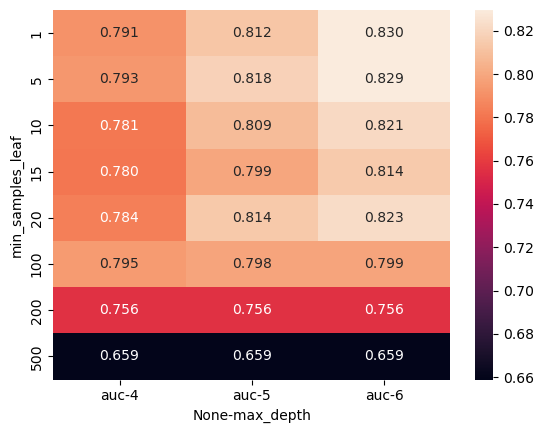

In [34]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f");

In [35]:
dt_model = DecisionTreeClassifier(max_depth=20, min_samples_leaf=7)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict_proba(X_val)[:, 1]

print('Decision Tree (AUC):', roc_auc_score(y_val, y_pred))

Decision Tree (AUC): 0.8626912840984697


In [36]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_val)[:, 1]
print('Random Forest (AUC):', roc_auc_score(y_val, y_pred))

Random Forest (AUC): 0.9125181010527965


In [37]:
features = dv.get_feature_names()
# dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
# dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

/opt/anaconda3/envs/zoomcamp-ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=175)


y_pred = xgb_model.predict(dval)
print('xg boost (AUC):', roc_auc_score(y_val, y_pred))

xg boost (AUC): 0.9131345152831593


In [39]:
sample_data = {
  "max_ground_temp": -9.0,
  "min_ground_temp": -77.0,
  "max_air_temp": -3.0,
  "min_air_temp": -81.0,
  "mean_pressure": 863.0,
  "weather": "Sunny"
  }

payload = dv.transform(sample_data)
dpayload = xgb.DMatrix(payload, label=y_train)
xgb_model.predict(dpayload)

array([0.69762254], dtype=float32)

#### 04. model export: bento

In [40]:
bentoml.xgboost.save_model(
    'uv_radiation_model',
    xgb_model,
    labels={"stage": "Midterm project", },
    custom_objects={ "dictVectorizer":dv }
    )

Model(tag="uv_radiation_model:r2rcuddbkkapddef", path="/Users/afrogrit/bentoml/models/uv_radiation_model/r2rcuddbkkapddef/")

In [41]:
!bentoml models get uv_radiation_model:latest


name: uv_radiation_model                                                        
version: r2rcuddbkkapddef                                                       
module: bentoml.xgboost                                                         
labels: {}                                                                      
options:                                                                        
  model_class: Booster                                                          
metadata: {}                                                                    
context:                                                                        
  framework_name: xgboost                                                       
  framework_versions:                                                           
    xgboost: 1.6.2                                                              
  bentoml_version: 1.0.7                                                        
  python_version: 3.9.13    

In [42]:
! bentoml models list

 Tag                           Module           Size        Creation Time       
 uv_radiation_model:r2rcuddb…  bentoml.xgboost  190.73 KiB  2022-11-11 01:51:12 
 uv_radiation_model:urexgddb…  bentoml.xgboost  190.89 KiB  2022-11-11 01:44:39 
 uv_radiation_model:dkd7l5db…  bentoml.xgboost  190.89 KiB  2022-11-11 01:33:38 
 uv_radiation_model:ay5u4rdb…  bentoml.xgboost  190.89 KiB  2022-11-11 01:25:55 
 uv_radiation_model:yqisx4tb…  bentoml.xgboost  190.89 KiB  2022-11-11 01:16:54 
 uv_radiation_model:bmesndtb…  bentoml.xgboost  190.89 KiB  2022-11-11 00:57:25 
 uv_radiation_model:4pj62ptb…  bentoml.xgboost  509.00 KiB  2022-11-10 23:37:35 
 uv_radiation_model:3lcw6xtb…  bentoml.xgboost  509.00 KiB  2022-11-10 23:15:51 
 uv_radiation_model:w3trxpdb…  bentoml.xgboost  509.00 KiB  2022-11-10 22:53:22 
 uv_radiation_model:ac37hvdb…  bentoml.xgboost  342.29 KiB  2022-11-10 19:49:19 
 credit_risk_model_hw7:uot7t…  bentoml.xgboost  114.20 KiB  2022-10-19 15:19:19 
 mlzoomcamp_homework:jsi67fs